# King County, WA (Seattle) Housing Price Prediction

Using a feed-forward neural network, we will predict the prices of homes in the Seattle area. Adpated from this guide: https://www.kaggle.com/ironfrown/deep-learning-house-price-prediction-keras

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import tensorflow.keras as keras # import Keras, the machine learning library
import matplotlib.pyplot as plt
import cmocean

/home/sridge/.conda/envs/ml_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sridge/.conda/envs/ml_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sridge/.conda/envs/ml_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sridge/.conda/envs/ml_env/lib/python3.6/site-pack

In [2]:
def plot_hist(h, xsize=6, ysize=10,dpi=300):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    return

# Read in data

In [3]:
df = pd.read_csv('data.csv')

# Data Exploration

In [4]:
print(df.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517    

Sometimes pd.plotting.scatter_matrix() can be useful for exploring what variables correlate well with with the predictand. I didn't find it very helpful in this case, mostly because many of these variables are closely related (look at all the square footage variables). Instead, I chose to plot the 2D historgram for a single variable, `sqft_living`. It's reasonable to assume that this variable, which I think represents the livable square footage of a home, would correlate highly with home price

# Linear Model

We use linear regression as the baseline for the simplest model architecture. Our neural network should do significantly better if want to justify using this more complicated, and potentially less interpretable, method

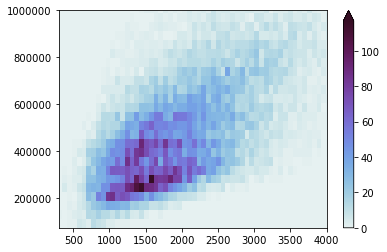

In [5]:
_,_,_,_=plt.hist2d(df.sqft_living, df.price,
              bins=200,cmap=cmocean.cm.dense)
plt.xlim(300,4000)
plt.ylim(7.5e4,1e6)
plt.colorbar(extend='max')

In [6]:
m, b, r_value, p_value, std_err = stats.linregress(df.sqft_living,df.price)

Text(2800, 250000.0, 'RMSE: $261,441')

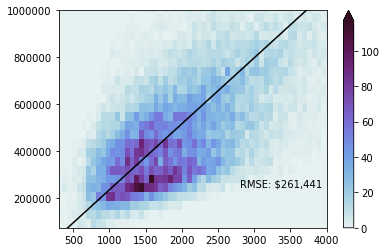

In [7]:
_,_,_,_=plt.hist2d(df.sqft_living, df.price,
              bins=200,cmap=cmocean.cm.dense)
plt.xlim(300,4000)
plt.ylim(7.5e4,1e6)
plt.colorbar(extend='max')

sqft = np.linspace(0,1e4,10)

y_lin = m*sqft + b

plt.plot(sqft,y_lin,color='k')

y_lin = m*df.sqft_living + b

rmse = (((df.price-y_lin)**2).sum()/len(y_lin))**0.5

plt.text(x=2800,y=2.5e5,s=f'RMSE: ${rmse:,g}')

# Feature selection and normalization for our neural network

Don't put in too many features. Adding features won't necessarily improve your model, but it will increase the training time and reduce interpretability.

In [8]:
feature_list = ['sqft_living','zipcode','bathrooms','bedrooms','waterfront','sqft_lot']

In [9]:
X = df[feature_list]

Y = df['price']

In [10]:
X_norm = (X-X.min())/X.max()

In [11]:
nx = len(X.columns)
ny = 1

In [12]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Set up our neural network

Here we create a simple neural network with two hidden layers. For some reason a hyperbolic tangent input layer yields better results

In [13]:
def simple_NN(nx, ny):
    model = keras.Sequential()
    model.add(keras.layers.Dense(32, activation='tanh', input_shape=(nx,))) 
    model.add(keras.layers.Dense(32, activation='relu')) # each time we invoke the .add() method, we add a layer
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(ny))
    print(model.summary())
    model.compile(loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.mae])
    return(model)

# Train without normalized data

In [14]:
model = simple_NN(nx,ny)

hist = model.fit(x=X, y=Y,
                     batch_size=128, epochs=500, verbose=0,
                     validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________
None


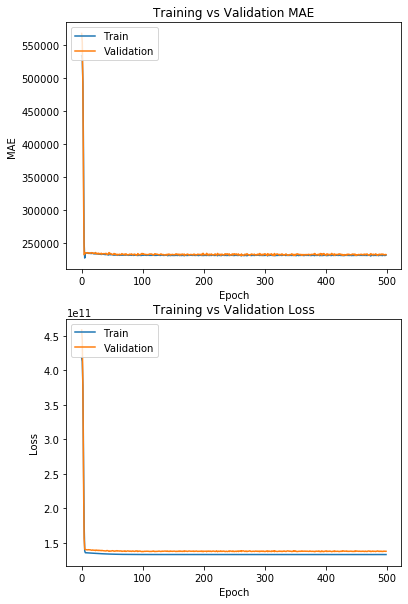

In [15]:
plot_hist(hist.history)

# Effect of normalizing inputs
Results: normalization yields more accurate predictions

In [16]:
hist = model.fit(x=X_norm, y=Y,
                     batch_size=128, epochs=500, verbose=0,
                     validation_split=0.2)

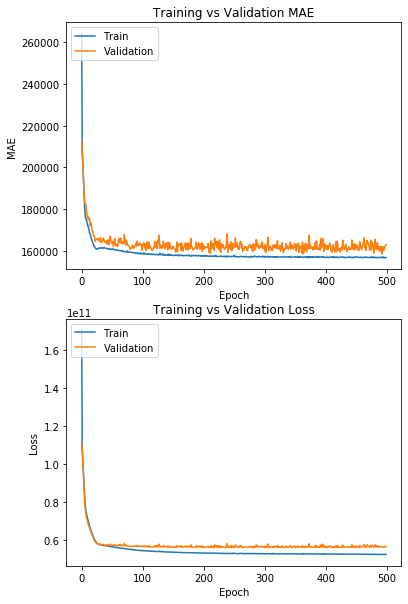

In [17]:
plot_hist(hist.history)

# Plot spatial pattern of bias
Here we can see that our model is biased low in a horizontal (zonal) band in the middle, and biased high north and south of that band. Maybe including lat/long would improve our model

In [18]:
Y_hat = model.predict(X_norm)
mod_err = Y_hat.squeeze()-Y

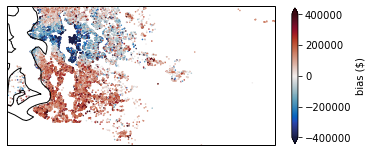

In [19]:
import cartopy
import cartopy.crs as ccrs

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([df.long.min(), df.long.max(), df.lat.min(), df.lat.max()], crs=ccrs.PlateCarree())
cax = plt.scatter(df['long'],df['lat'],c=mod_err,cmap=cmocean.cm.balance,vmin=-4e5,vmax=4e5,s=.25)
plt.colorbar(shrink=0.25,label='bias ($)',extend='both')
ax.coastlines(resolution='10m')

# Add Lat/Long as an input

In [20]:
X = df[feature_list+['lat','long']]

Y = df['price']

In [21]:
X_norm = (X-X.min())/X.max()
X_norm = (X-X.mean())/X.std()

In [22]:
nx = len(X.columns)
ny = 1

In [23]:
model = simple_NN(nx,ny)

hist = model.fit(x=X_norm, y=Y,
                     batch_size=128, epochs=100, verbose=0,
                     validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________
None


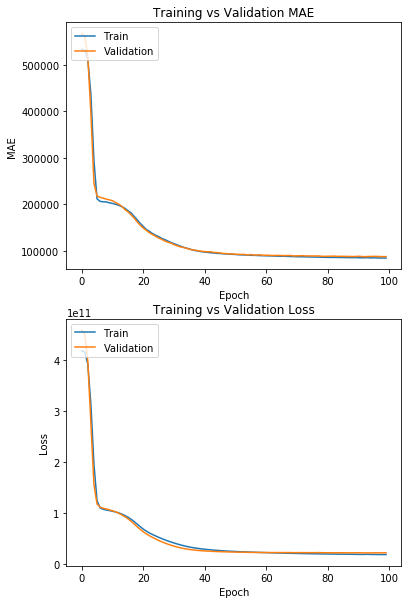

In [24]:
plot_hist(hist.history)

In [25]:
Y_hat = model.predict(X_norm)
mod_err = Y_hat.squeeze()-Y

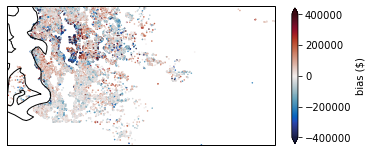

In [26]:
import cartopy
import cartopy.crs as ccrs

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([df.long.min(), df.long.max(), df.lat.min(), df.lat.max()], crs=ccrs.PlateCarree())
cax = plt.scatter(df['long'],df['lat'],c=mod_err,cmap=cmocean.cm.balance,vmin=-4e5,vmax=4e5,s=.25)
plt.colorbar(shrink=0.25,label='bias ($)',extend='both')
ax.coastlines(resolution='10m')

### Below is a figure of waterfront homes. Prediction of home prices near the waterfront are biased low in value. This is because despite not being listed as waterfront, they likely have waterviews that boost their value.

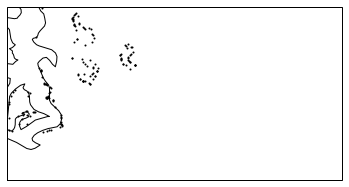

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([df.long.min(), df.long.max(), df.lat.min(), df.lat.max()], crs=ccrs.PlateCarree())
cax = plt.scatter(df['long'].loc[df.waterfront==1],df['lat'].loc[df.waterfront==1],c='k',cmap=cmocean.cm.thermal,vmin=0,vmax=1e6,s=1)

ax.coastlines(resolution='10m')

# Actual Price

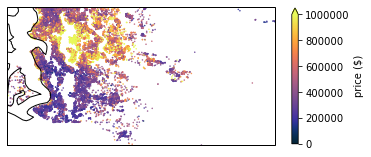

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([df.long.min(), df.long.max(), df.lat.min(), df.lat.max()], crs=ccrs.PlateCarree())
cax = plt.scatter(df['long'],df['lat'],c=df.price,cmap=cmocean.cm.thermal,vmin=0,vmax=1e6,s=.25)
plt.colorbar(shrink=0.25,label='price ($)',extend='max')
ax.coastlines(resolution='10m')

# Predicted price

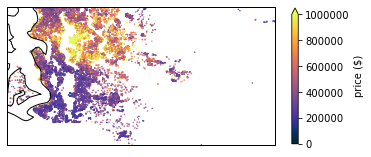

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([df.long.min(), df.long.max(), df.lat.min(), df.lat.max()], crs=ccrs.PlateCarree())
cax = plt.scatter(df['long'],df['lat'],c=Y_hat.squeeze(),cmap=cmocean.cm.thermal,vmin=0,vmax=1e6,s=.25)
ax.coastlines(resolution='10m')
plt.colorbar(shrink=0.25,label='price ($)',extend='max')

In [30]:
model.evaluate(X_norm,Y)

21613/21613 [==============================] - 0s 6us/step


[19582262187.097027, 84211.07112725847]

In [31]:
model.metrics_names

['loss', 'mean_absolute_error']